Set our directory to the project location

In [4]:
import os
print("Current directory is: " + os.getcwd())

os.chdir("F:\BDRAD MiniProject\Breast Project")
#main working directory
home_dir = os.getcwd()
print("Changing directory to: " + home_dir)

Current directory is: F:\BDRAD MiniProject\Breast Project
Changing directory to: F:\BDRAD MiniProject\Breast Project


In [4]:
import os #directory operations
import re #for regular expression string functions
import csv #will need to extract labels from csv files

# cwd = os.getcwd()
# #store current directory as string
# dir_list = os.listdir(cwd)
# #store list of directories within cwd
# print(cwd, "\n", dir_list, "\n", dir_list[1])
# #create next directory using 
# print("End of testing", "*"*45)

def CSVDensityDictionary(read_csv): 
    #read csv file containing density information, match patient idenfitiers and density label and create python dictionary
    #return a dictionary of patient ID as key with dense or not dense (1 or 0) as value
    DataLabelsDictionary = {} #initialize empty dictionary
    DataLabels = []
    with open(read_csv) as csv_file:
        csv_data = csv.reader(csv_file, delimiter = ",")
        for row in csv_data: #note this reads the entire CSV file but we're only using a subset of the data inside
            DataLabels.append(row[0:2])
    
    
    DataLabels.remove(DataLabels[0]) #remove headers
    
    for i in DataLabels:
        #each list i in DataLabels contains patient data and patient breast density
        if not i[0] in DataLabelsDictionary.keys(): #if i[0] is in dictionary this will return false
            #this is so we dont' have repeats. upon manual inspection of data, if patient # is the same, the breast density is also the same
            if(int(i[1])<=2): #the i[1] data are strings, convert to integers, values 1-2 are not dense (0) , 3-4 are dense (1)     
                DataLabelsDictionary.update({i[0]:0}) #0 will represent Not Dense, i[0] is patient ID which will act as key
            else:
                DataLabelsDictionary.update({i[0]:1}) #1 will represent Dense
            #note if we wanted 1-4 as categories we could just do a i[0]:int(i[1]) update and write from data directly
    
       
    return DataLabelsDictionary
        

def DICOMExtract(filepath,DensityDictionary):
    #start from filepath and systematically walk topdown through all directories/subdirectories
    #store a list of tuples of root, subdirs within root, files within root
    #iterate over this list of tuples to search for dcm files
    #create new list of tuples to append file path of dcm files,name of dcm file, extract patient ID from file path,
    #use extracted patient ID to find associated breast density using density dictionary acquired fromCSVDensityDictionary
    list_tuples=[] #list of tuples
    for (root_path, sub_dirs, files) in os.walk(filepath,topdown=True):
        list_tuples.append((root_path,sub_dirs,files))
        #print ("Root Path: ", root_path)
        #print ("Sub directories: ", sub_dirs)
        #print ("Files: ",files)
        #print ("-" * 25)

    dcm_list=[]

    for i in list_tuples:
        #iterate over each tuple collected from os.walk
        #print(i[2]) # used for debugging
        if bool(i[2]): #check if file name tuple is empty, returns TRUE if there is something there otherwise FALSE if empty
            for j in i[2]: #more generalizable if we search over all files instead of just assuming there is 1 file
                if(bool(re.search("dcm", j))): #if not empty, see if file type dcm is among the files
                #note i[2] returns a list object, so need to access the actual elements within that list
                    #print('dcm file found')
                    PatientNumberIndex = i[0].find("_P_")+1 #+1 because find will return index of first _ but we it would be better to get index of P, it is done this way for more robustness since _P_ is less likely to occur in a file path than P_
                    PatientNumber=i[0][PatientNumberIndex:PatientNumberIndex+7]
                    #acquire next 7 characters starting at found index of letter P because all patient numbers are 
                    #in format of P_XXXXX , use 7 instead of 6 since python doesn't include the last number in array (eg a[1:3] will not include a[3])
                    dcm_list.append((i[0],j,PatientNumber,DensityDictionary.get(PatientNumber)))
                    #create another list of tuples but this one ONLY contains file paths to DCM files
                    #Also includes Patient number as a string, also includes density label from CSV file
                    
                    #1st element i[0] is a tuple containing the directory
                    #2nd element i[1] in each tuple is the file list, j is the string in i[2] that matched dcm in name
                    #3rd element is the Patient ID as a string
                    #4th element is the density associated with the Patient ID as an integer 0 or 1
#                 else:
#                     print('no') #no dcm files found despite files not being empty, used for debugging
#         else:
#             print('no') #file tuple is empty used for debugging
    print("%d DICOM files found" %(len(dcm_list)))
    return dcm_list

filepath_training = home_dir +"\Breast Images\Breast Training"
filepath_test = home_dir + "\Breast Images\Breast Test"
#location of image data

test_csv ="mass_case_description_test_set.csv"
training_csv = "mass_case_description_train_set.csv"

TestDictionary = CSVDensityDictionary(test_csv)
TrainingDictionary = CSVDensityDictionary(training_csv)

dcm_list_training = []
dcm_list_test = []

dcm_list_training = DICOMExtract(filepath_training,TrainingDictionary)
dcm_list_test = DICOMExtract(filepath_test,TestDictionary)

print("Training Dictionary Entries: %d " %(len(TrainingDictionary)))
print("Test Dictionary Entries: %d " %(len(TestDictionary)))
#note the dictionary is for the entire CSV file, so it will have more entries than our data files which is a subset
#also note that we used unique patient identifiers so that the dictionary will have fewer entries than there are rows in the csv
#print(dcm_list_training[200:205])

400 DICOM files found
115 DICOM files found
Training Dictionary Entries: 691 
Test Dictionary Entries: 201 


These are the indices chosen (not patient ID) [16, 42, 104, 118, 156, 188, 246, 249, 319, 365]
Below is the numpy array of Patient ID P_00061 

[[    0     0     0 ... 48151 64312 65535]
 [    0     0     0 ... 45003 63277 65535]
 [    0     0     0 ... 46808 63827 65535]
 ...
 [    0     0     0 ... 25056 31220 56738]
 [    0   177     0 ... 25254 31573 56958]
 [    0     0     0 ... 24769 30009 55571]]


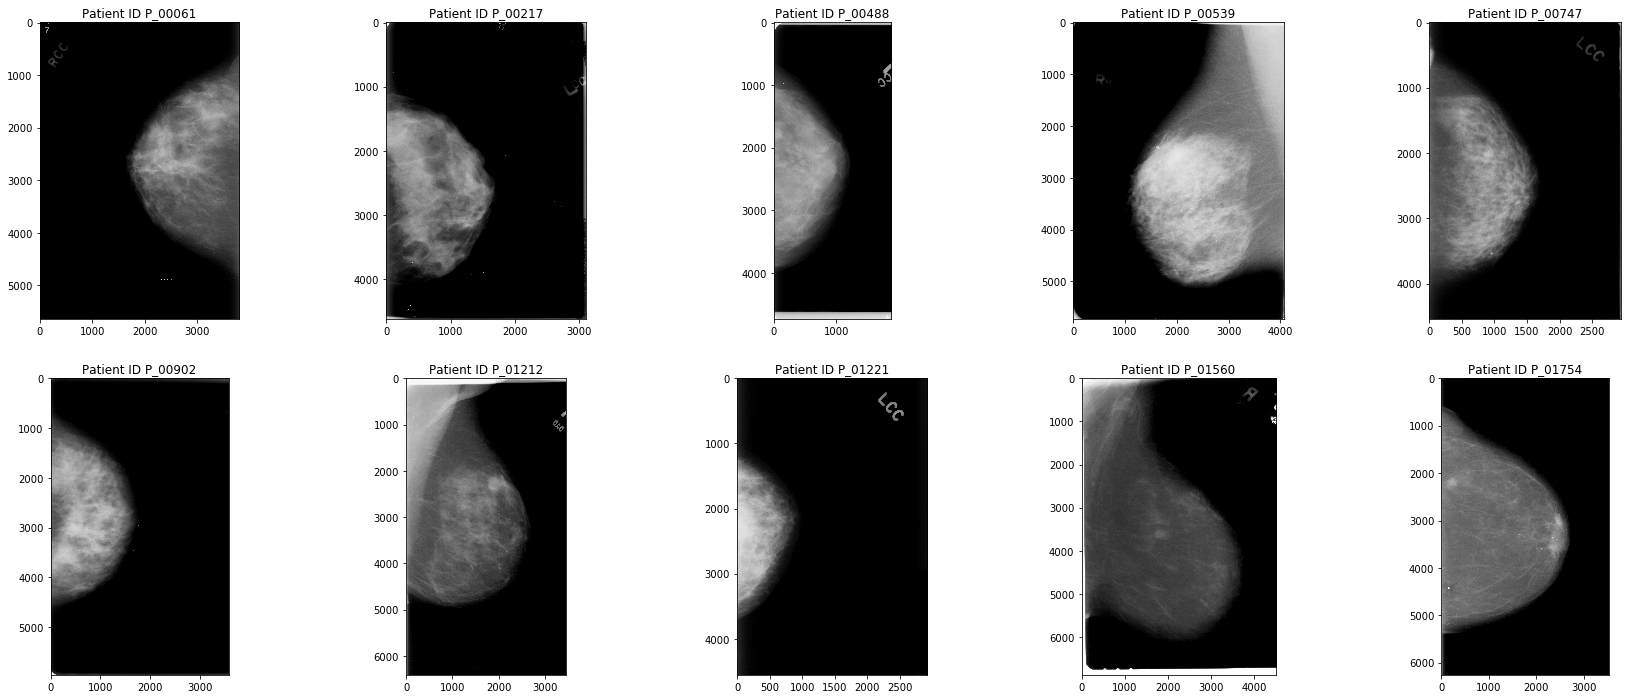

In [6]:
import random
import pydicom #for extracting data from DICOM
import matplotlib.pyplot as plt #display images,pyplot is not imported with matplotlib with simply import matplotlib
#random.seed(215) #for consistency but otherwise it is quite random
figBreasts, axes = plt.subplots(nrows=2, ncols=5)

figBreasts.set_figheight(12)
figBreasts.set_figwidth(30)
RandomImageIndex = random.sample(range(1,len(dcm_list_training)),10)
RandomImageIndex.sort()
#randomly pick 10 numbers from 1 to length of list and then sort it
print("These are the indices chosen (not patient ID)", RandomImageIndex)

plt.figure(figBreasts.number)

def dcmRead(dcmElement):
    #dcmRead outputs a pydicom struct
    #for 1 element, obtain filepath to DCM file using our format of dcm_list tuples then read using pydicom and return pydicom file
    image_path = dcmElement[0] + "\\" + dcmElement[1]
    ds = pydicom.dcmread(image_path)
    return ds

for i in range(10):
    #image_path = dcm_list_training[RandomImageIndex[i]][0] + "\\" + dcm_list_training[RandomImageIndex[i]][1]
    #ds = pydicom.dcmread(image_path)
    ds = dcmRead(dcm_list_training[RandomImageIndex[i]])
    plt.subplot(2,5,i+1).set_title("Patient ID %s" %(dcm_list_training[RandomImageIndex[i]][2]))
    plt.imshow(ds.pixel_array, cmap="gray")
    if i == 0:
        print("Below is the numpy array of Patient ID %s \n" %(dcm_list_training[RandomImageIndex[i]][2]))
        print(ds.pixel_array)
        
plt.show()

#note the patient ID in each set do not increase consecutively aka the 400 in training set ranges from P_00001 to P_02079


<class 'numpy.ndarray'>


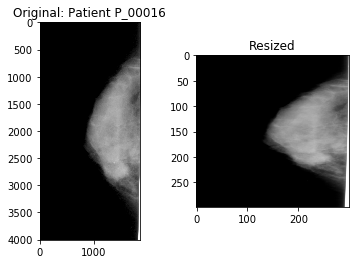

***************************************************************************
P_00001


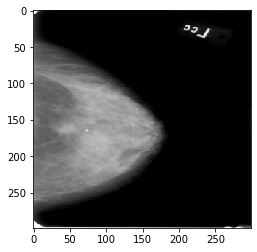

In [7]:
import numpy as np
import pydicom #for extracting data from DICOM
import matplotlib.pyplot as plt
from skimage.transform import resize


def DICOMResize(ds,height,width):
    #DICOMResize takes a pydicom struct and outputs a resized numpy ndarray
        img_original = ds.pixel_array
        img_resize = resize(img_original,(height,width))
        return img_resize
        

img_resize=DICOMResize(dcmRead(dcm_list_test[0]),height=299,width=299)        


plt.subplot(1,2,1).set_title("Original: Patient %s" %(dcm_list_test[0][2]))
plt.imshow((dcmRead(dcm_list_test[0])).pixel_array,interpolation='nearest',cmap="gray")
plt.subplot(1,2,2).set_title("Resized")
plt.imshow(img_resize,interpolation='nearest',cmap="gray")
print(type(img_resize)) #check to make sure output was indeed a numpy array
plt.show()

print("***"*25)

img_resize=DICOMResize(dcmRead(dcm_list_training[0]),height=299,width=299) 
plt.imshow(img_resize,interpolation='nearest',cmap="gray")
print(dcm_list_training[0][2])
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt


#will be a tuple containing 1st element patient ID, 2nd element resized image, 3rd element density information

def ResizeCompile(dcm_list):
    list_resized=[]
    for i in range(len(dcm_list)): #dcm_list is n tuples where n is number of dicoms in the list
        ds = dcmRead(dcm_list[i])
        ds_resize=DICOMResize(ds,299,299)
        list_resized.append((dcm_list[i][2],ds_resize,dcm_list[i][3]))
    return list_resized

#Only need to run below blocks once

# Compiled_Resized_Training = ResizeCompile(dcm_list_training)
# print(len(Compiled_Resized_Training))
# np.savez_compressed('ResizedTrainingCompressed.npz', Master_Data=Compiled_Resized_Training)
# print("Save Complete \n")

# Compiled_Resized_Test = ResizeCompile(dcm_list_test)
# print(len(Compiled_Resized_Test))
# np.savez_compressed('ResizedTestCompressed.npz',Master_Data=Compiled_Resized_Test)
# print("Save Complete \n")   







400
Save Complete 



In [17]:
loaded_data = np.load("ResizedTraining.npz",allow_pickle=True)
print(loaded_data['Master_Data'][0:5])


[['P_00001'
  array([[0.99998474, 0.99998474, 0.99998474, ..., 0.54456652, 0.54711881,
        0.54870736],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.35103934, 0.35648413,
        0.35766997],
       [0.99998474, 0.99998474, 0.99996948, ..., 0.04019114, 0.04222347,
        0.04288102],
       ...,
       [0.99998474, 0.99998474, 0.99998474, ..., 0.26794384, 0.26814883,
        0.26841419],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.33050694, 0.32900271,
        0.32913177],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.4211159 , 0.42277043,
        0.4225252 ]])
  1]
 ['P_00004'
  array([[0.99690383, 0.9999558 , 0.99998474, ..., 0.93932624, 0.95302265,
        0.96250414],
       [0.99995449, 0.99998474, 0.99998474, ..., 0.75077952, 0.82795613,
        0.86897529],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.55812487, 0.59827884,
        0.62241999],
       ...,
       [0.99998474, 0.99998474, 0.99998474, ..., 0.99998474, 0.99998474,
        0.99998474],
  

range(0, 5)

In [1]:
# import tensorflow as tf
# import matplotlib
# import torch

# print(tf.__version__)
# print(matplotlib.__version__)
# print(torch.__version__)

2.0.0
3.1.2
1.3.1


In [2]:
# size = torch.Size([2,2])
# x = torch.empty(size)
# print(x)
# print(size)

tensor([[0., 0.],
        [0., 0.]])
torch.Size([2, 2])


In [4]:



#import glob
#glob is a python function to match spcified patterns - use glob function in glob library
#datapath="F:/Files and Media/Programming Data/Breast Images/Breast Test/CBIS-DDSM/Mass-Test_P_00016_LEFT_CC/10-04-2016-DDSM-30104/1-full mammogram images-14172"
#filepath=glob.glob(datapath + "/*.dcm")

##################

# def DicomRead(imagepath):
#     
#     #ds will be shorthand for dataset
#     print(ds, "\n")
#     # print(dir(ds), "\n")


###########

# imagepath = os.getcwd() + "\\000000.dcm"
# #\0 is null char in python, so for building file path use \\ for string \
# print(imagepath,"\n")

 

# rows = ds.Rows
# columns = ds.Columns
# size = len(ds.PixelData)
# print("Image Size......... %d rows x %d columns with %d bytes" %(rows, columns, size), "\n")

# print(ds.pixel_array) 
# plt.imshow(ds.pixel_array)
# plt.show();


#need to match CSV row ID with patient ID associated with each DICOM to append a breast density classification

##############

# for i in range(0,1):
#     image_path = dcm_list_training[RandomImageIndex[i]][0] + "\\" + dcm_list_training[RandomImageIndex[i]][1]
#     ds = pydicom.dcmread(image_path)
#     #og_img = cv2.imread(ds.pixel_array)
#     #res_img = cv2.resize(og_img,dsize(299,299), interpolation = cv2.INTER_CUBIC)
#     img_original = ds.pixel_array
#     img_resize = resize(img_original, (299,299))
#     plt.subplot(1,2,i+1).set_title("Original")
#     plt.imshow(img_original,interpolation='nearest')
#     plt.subplot(1,2,i+2).set_title("Resized")
#     plt.imshow(img_resize,interpolation='nearest')

#############

# ds_export = dcmRead(dcm_list_training[0])
# ds_export_resized=DICOMResize(ds_export,299,299)

# print(ds_export_resized.shape)


##################

#print(list_resized[1][1].shape)
#numpy.savez_compressed("test.npz",ds_export_resized,delimiter=',')
#test = numpy.loadtxt("test.csv", delimiter=',')